## Imports

In [1]:
import functools

%matplotlib inline
import numpy as np

import pyro
import pyro.distributions as dist
import torch

from pyro_webppl import viz

Here we show a few PyroWebPPL primitives. In later chapters, these will be imported from `pyro_webppl`.

In [2]:
def flip(p=0.5):
    return torch.distributions.Bernoulli(p).sample()

def pflip(var='flip', p=0.5):
    return pyro.sample(var, dist.Bernoulli(p))

def repeat(f, n):
    return [f() for _ in range(n)]

# Models, simulation, and degrees of belief

<!--
robert_hawkins [11:49 AM]  
a couple issues with the chapter:
1. the heading structure is a bit confusing — the “Building Generative Models” section starts with some info on webppl, has a subsection “example: flipping coins”, and then pops out to the outer level for “example: medical diagnosis”. Maybe we could signpost that better, like create a subsection where we explicitly describe webppl, a subsection about sampling, and indent the medical diagnosis example one level?
2. the “prediction, simulation, and probabilities” section uses both bayesian and frequentist notions of probability without labeling them or distinguishing them (e.g. “A probability is… a degree of belief”, but “We may define the probability … to be the fraction of times (in the long run) that this value is returned”). It’d be nice to say that these are alternate ways of formalizing probability?
3. I like the new "constructing marginal distributions with `Infer`" section… Should we rewrite other models in future chapters that use `repeat` to use `forward` instead?
-->



One view of knowledge is that the mind maintains working models of parts of the world.
'Model' in the sense that it captures some of the structure in the world, but not all (and what it captures need not be exactly what is in the world---just what is useful).
'Working' in the sense that it can be used to simulate this part of the world, imagining what will follow from different initial conditions.
As an example take the Plinko machine: a box with uniformly spaced pegs, with bins at the bottom.
Into this box we can drop marbles:



<img src="../img/plinko.gif" width="300">

<a href="https://probmods.org/chapters/generative-models.html"> Interactive example </a>


The plinko machine is a 'working model' for many physical processes in which many small perturbations accumulate---for instance a leaf falling from a tree.
It is an approximation to these systems because we use a discrete grid (the pegs) and discrete bins.
Yet it is useful as a model: for instance, we can ask where we expect a marble to end up depending on where we drop it in, by running the machine several times---simulating the outcome.

Imagine that someone has dropped a marble into the plinko machine; before looking at the outcome, you can probably report how much you believe that the ball has landed in each possible bin.
Indeed, if you run the plinko machine many times, you will see a shape emerge in the bins.
The number of balls in a bin gives you some idea how much you should expect a new marble to end up there.
This 'shape of expected outcomes' can be formalized as a probability distribution (described below).
Indeed, there is an intimate connection between simulation, expectation or belief, and probability, which we explore in the rest of this section.

There is one more thing to note about our Plinko machine above: we are using a computer program to *simulate* the simulation.
Computers can be seen as universal simulators.
How can we, clearly and precisely, describe the simulation we want a computer to do?

# Building Generative Models

We wish to describe in formal terms how to generate states of the world.
That is, we wish to describe the causal process, or steps that unfold, leading to some potentially observable states.
The key idea of this section is that these generative processes can be described as *computations*---computations that involve random choices to capture uncertainty about the process.

Programming languages are formal systems for describing what (deterministic) computation a computer should do. Modern programming languages offer a wide variety of different ways to describe computation; each makes some processes simple to describe and others more complex. 

However, a key tenet of computer science is that all of these languages have the same fundamental power: any computation that can be described with one programming language can described by another. More technically, this Church-Turing thesis posits that many specific computational systems capture the set of all effectively computable procedure - these are called *universal* systems.

<!--
As our formal model of computation we start with the $$\lambda$$-calculus, and its embodiment in the LISP family of programming languages.
The $$\lambda$$-calculus is a formal system which was invented by Alonzo Church in 1936 as a way of formalizing the notion of an effectively computable function [@Church1936].
The $$\lambda$$-calculus has only two basic operations for computing: creating and applying functions.
Despite this simplicity, it is a *universal* model of computation---it is (conjectured to be) equivalent to all other notions of classical computation.
(The $$\lambda$$-calculus was shown to have the same computational power as the Turing machine, and vice versa, by Alan Turing in his famous paper which introduced the Turing machine [@Turing1937]).
-->

<!--
In 1958 John McCarthy introduced LISP (**LIS**t **P**rocessing), a programming language based on the $$\lambda$$-calculus.
Scheme is a variant of LISP developed by Guy L.
Steele and Gerald Jay Sussman with particularly simple syntax and semantics.
We will use Scheme-style notation for the $$\lambda$$-calculus in this tutorial.
For a quick introduction to programming in Scheme see [the appendix on Scheme basics](appendix-scheme.html).
The Church programming language [@Goodman2008], named in honor of Alonzo Church, is a generalization of Scheme which introduces the notion of probabilistic computation to the language.
This addition results in a powerful language for describing generative models.
-->

<!-- 
In this book we will build on the JavaScript language, which is a portable and flexible modern programming language.
The [WebPPL language](http://webppl.org) takes a subset of JavaScript and extends it with pieces needed to describe *probabilistic* computation.
The key idea is that we have primitive operations that describe not only deterministic functions (like `and`) but stochastic operations.
In WebPPL, in addition to deterministic functions, we have a set of random functions implementing *random choices.*  These random primitive functions are called *Exchangeable Random Primitives* (XRPs).
Application of an XRP results in a *sample* from the probability distribution defined by that XRP.
-->

<a href="http://pyro.ai/"><img src="../img/pyro_logo.png" width="200"></a>

In this book we will build on Pyro, a powerful modern probabilistic programming language (PPL) supporting traditional statical models, to complex neural ML models, as well as hybrids and everything in-between. The Pyro probabilistic programming language extends Python with pieces needed to describe *probabilistic* computation. 

**Pyro Links**:
* [Github](https://github.com/pyro-ppl/pyro)
* [Website](http://pyro.ai/)
* [Examples and Tutorials](http://pyro.ai/examples/)
* [Forum](https://forum.pyro.ai)

## PyroWebPPL

For this book, we introduce a basic, minimal implementation of [WebPPL](http://webppl.org/) operators using Pyro as a backend for key PPL functionality. Code for this implementation can be found in the `src` directory for this project.

The PyroWebPPL examples in this book can serve as a stepping stone to learning Pyro. Readers are encouraged to explore `src/webppl.py` and `src/infer.py` to better understand Pyro. Adventurous readers may add breakpoints or print statements to the source code to examine pyro variables used in the relatively simple examples present in this book.

## Probabilistic Programming

The key idea is that we have primitive operations that describe not only deterministic functions (like `and`) but stochastic operations.


For example, the `flip` function can be thought of as simulating a (possibly biased) coin toss (technically `flip` samples from a Bernoulli distribution, which we'll return to shortly):

In [3]:
flip()

tensor(1.)

Running this program a few times, we get back a different sample on each execution.

In [4]:
for _ in range(10):
    s = flip()
    print(s)

tensor(0.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


Notice the parentheses after `flip`, indicating that you are calling the `flip` function, resulting in a sample. Without parentheses `flip` is a *function object* - a representation of the simulator itself, which can be used to get samples.

In Pyro, each time you run a program you get a *sample* by simulating the computations and random choices that the program specifies. If you run the program many times, and collect the values in a histogram, you can see what a typical sample looks like:

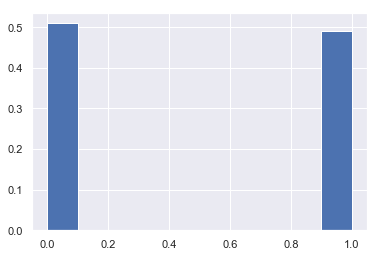

In [5]:
samples = repeat(flip, 1000)
viz(samples)

Here we have used the `repeat` procedure which takes a number of repetitions, $K$, and a function (in this case `flip`) and returns a list of $K$ samples from that function.
We have used the `viz` function to visualize the results of calling the `flip` function 1000 times.
As you can see, the result is an approximately uniform distribution over `true` and `false`.

Using `flip` we can construct more complex expressions that describe more complicated sampling processes. For instance here we describe a process that samples a number adding up several flips:

In [6]:
for _ in range(10):
    s = flip() + flip() + flip()
    print(s)

tensor(3.)
tensor(3.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(2.)
tensor(3.)
tensor(1.)
tensor(2.)


What if we want to invoke this sampling process multiple times? We would like to construct a stochastic function that adds three random numbers each time it is called.
We can use `def` to construct such complex stochastic functions from the primitive ones.

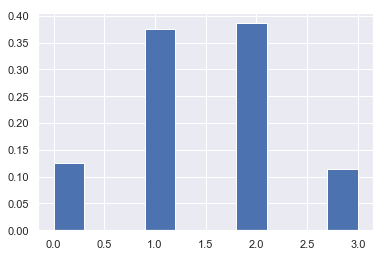

In [7]:
sum_flips = lambda: flip() + flip() + flip()
viz(repeat(sum_flips, 1000))


A function expression with an empty argument list, `def f(): ...`, is called a *thunk*: this is a function that takes no input arguments. If we apply a thunk (to no arguments) we get a return value back, for example `flip()`.
<!--A thunk is an object that represents a whole *probability distribution*.-->
Complex functions can also have arguments. Here is a stochastic function that will only sometimes double its input:


In [8]:
noisy_double = lambda x: (x+x if flip() else x)

for _ in range(10):
    s = noisy_double(3)
    print(s)

6
3
3
6
6
6
3
3
6
6



By using higher-order functions we can construct and manipulate complex sampling processes.
A good example comes from coin flipping...

## Example: Flipping Coins

The following program defines a fair coin, and flips it 20 times:

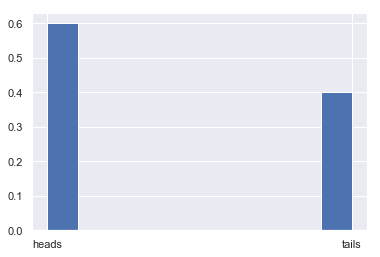

In [9]:
fair_coin = lambda: ('heads' if flip(0.5) else 'tails')
viz(repeat(fair_coin, 20))

This program defines a "trick" coin that comes up heads most of the time (95%), and flips it 20 times:

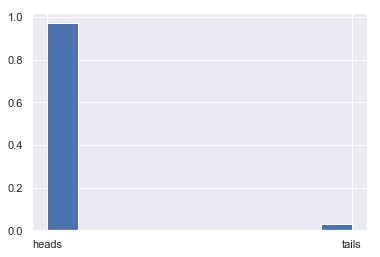

In [10]:
trick_coin = lambda: ('heads' if flip(0.95) else 'tails')
viz(repeat(trick_coin, 100))

The higher-order function `make_coin` takes in a weight and outputs a function (a thunk) describing a coin with that weight.  Then we can use `make_coin` to make the coins above, or others.

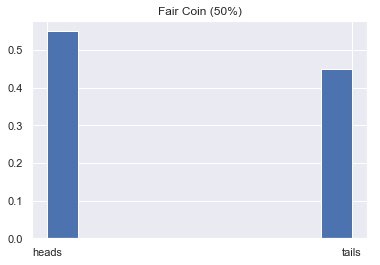

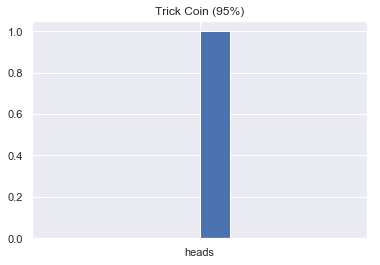

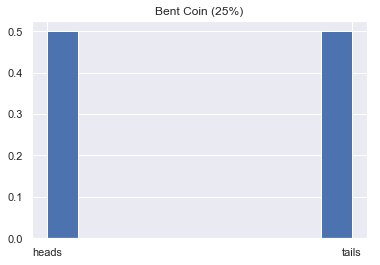

In [11]:
def make_coin(weight): 
    return lambda: ('heads' if flip(weight) else 'tails')

trick_coin = make_coin(0.95);
fair_coin = make_coin(0.5);
bent_coin = make_coin(0.25);

viz(repeat(fair_coin, 20), title='Fair Coin (50%)')
viz(repeat(trick_coin, 20), title='Trick Coin (95%)')
viz(repeat(bent_coin, 20), title='Bent Coin (25%)')

We can also define a higher-order function that takes a "coin" and "bends it":

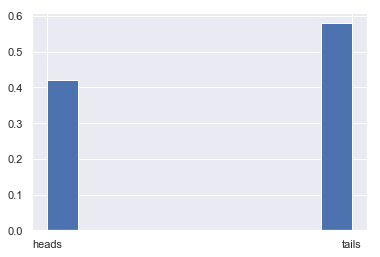

In [12]:
def make_coin(weight): 
    return lambda: ('heads' if flip(weight) else 'tails')

def bend_coin(coin):
    return lambda: (make_coin(0.7)() if (coin() == 'heads') else make_coin(0.1)())

fair_coin = make_coin(0.5)
bent_coin = bend_coin(fair_coin)
viz(repeat(bent_coin, 100))

Make sure you understand how the `bend_coin` function works! Why are there an "extra" pair of parentheses after each `make_coin` statement?

Higher-order functions like `for`, `while`, `map`, and `filter` can be quite useful.
Here we use them to visualize the number of heads we expect to see if we flip a weighted coin (weight = 0.8) 10 times.
We'll repeat this experiment 1000 times and then use `viz` to visualize the results.
Try varying the coin weight or the number of repetitions to see how the expected distribution changes.

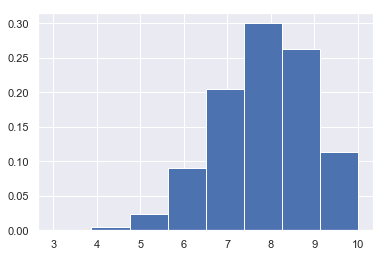

In [13]:
def make_coin(weight): 
    return lambda: flip(weight)

coin = make_coin(0.8)
samples_per_exp = 10 
num_exps = 1000

fn = repeat(lambda: sum(repeat(coin, samples_per_exp)), num_exps)
viz(fn, plot_args={'bins': 8})

## Example: Causal Models in Medical Diagnosis

Generative knowledge is often *causal* knowledge that describes how events or states of the world are related to each other.

As an example of how causal knowledge can be encoded in PyroWebPPL expressions, consider a simplified medical scenario:

In [14]:
lung_cancer = flip(0.01)
cold = flip(0.2)
cough = (cold or lung_cancer)
print(bool(cough))

False


This program models the diseases and symptoms of a patient in a doctor's office.
It first specifies the base rates of two diseases the patient could have: lung cancer is rare while a cold is common, and there is an independent chance of having each disease.
The program then specifies a process for generating a common symptom of these diseases -- an effect with two possible causes: The patient coughs if they have a cold or lung cancer (or both).

Here is a more complex version of this causal model:

In [15]:
lung_cancer = flip(0.01)
TB = flip(0.005)
stomach_flu = flip(0.1)
cold = flip(0.2)
other = flip(0.1)

cough = (
    (cold and flip(0.5)) or
    (lung_cancer and flip(0.3)) or
    (TB and flip(0.7)) or
    (other and flip(0.01)))

fever = (
    (cold and flip(0.3)) or
    (stomach_flu and flip(0.5)) or
    (TB and flip(0.1)) or
    (other and flip(0.01)))

chest_pain = (
    (lung_cancer and flip(0.5)) or
    (TB and flip(0.5)) or
    (other and flip(0.01)))

shortness_of_breath = (
    (lung_cancer and flip(0.5)) or
    (TB and flip(0.2)) or
    (other and flip(0.01)))

symptoms = {
  'cough': bool(cough),
  'fever': bool(fever),
  'chest_pain': bool(chest_pain),
  'shortness_of_breath': bool(shortness_of_breath),
}

symptoms

{'cough': False,
 'fever': False,
 'chest_pain': False,
 'shortness_of_breath': False}

Now there are four possible diseases and four symptoms.
Each disease causes a different pattern of symptoms.
The causal relations are now probabilistic: Only some patients with a cold have a cough (50%), or a fever (30%).
There is also a catch-all disease category "other", which has a low probability of causing any symptom.
*Noisy logical* functions---functions built from **and** (`&&`), **or** (`||`), and `flip`---provide a simple but expressive way to describe probabilistic causal dependencies between Boolean (true-false valued) variables.

When you run the above code, the program generates a list of symptoms for a hypothetical patient.
Most likely all the symptoms will be false, as (thankfully) each of these diseases is rare.
Experiment with running the program multiple times.
Now try modifying the `var` statement for one of the diseases, setting it to be true, to simulate only patients known to have that disease.
For example, replace `var lungCancer = flip(0.01)` with `var lungCancer = true`.
Run the program several times to observe the characteristic patterns of symptoms for that disease.


# Prediction, Simulation, and Probabilities

Suppose that we flip two fair coins, and return the list of their values:

In [16]:
[flip(), flip()]

[tensor(0.), tensor(0.)]

How can we predict the return value of this program?
For instance, how likely is it that we will see `[true, false]`?
A **probability** is a number between 0 and 1 that expresses the answer to such a question: it is a degree of belief that we will see a given outcome, such as `[true, false]`.
The probability of an event $A$ (such as the above program returning `[true, false]`) is usually written as: $P(A)$.

A **probability distribution** is the probability of each possible outcome of an event. For instance, we can examine the probability distribution on values that can be returned by the above program by sampling many times and examining the histogram of return values:

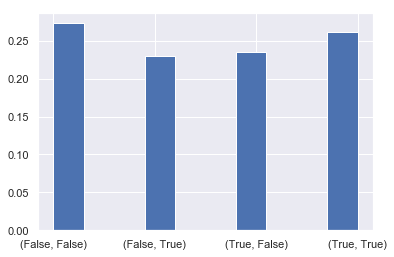

In [17]:
random_pair = lambda: (bool(flip()), bool(flip()))

n = 1000
viz(repeat(random_pair, n), to_type=str)


We see by examining this histogram that `[true, false]` comes out about 25% of the time.
We may define the probability of a return value to be the fraction of times (in the long run) that this value is returned from evaluating the program -- then the probability of `[true, false]` from the above program is 0.25.


# Distributions in Pyro

An important idea is that `flip` can be thought of in two different ways.
From one perspective, `flip` is a procedure which returns a sample from a fair coin.
That is, it's a *sampler* or *simulator*. As we saw above we can build more complex samplers by building more complex functions.

From another perspective, `flip` is *itself* a characterization of the probability distribution over `true` and `false`.

In order to make this view explicit, PyTorch has a special type of **distribution** objects. These are objects that can be sampled from using the `sample` operator, and that can explicitly return the probability of a return value using the `score` method. Distributions are made by a family of distribution constructors:

type  <class 'pyro.distributions.torch.Bernoulli'>
sample  tensor(1.)
log prob  tensor(-0.6931)


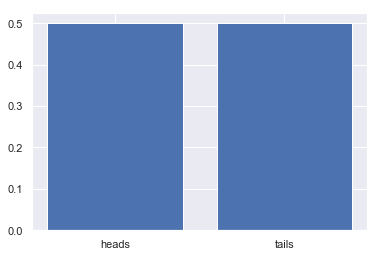

In [18]:
# make a distribution using the Bernoulli constructor:
d = dist.Bernoulli(0.5)
print('type ', type(d))

# sample from it with the sample operator:
print('sample ', d.sample())

# compute the log-probability of sampling true:
print('log prob ', d.log_prob(False))

# visualize the distribution:
plt.xticks([0, 1], labels=['heads', 'tails'])
viz(d, to_type=float)

In fact `flip(x)` is just a helper function that constructs a Bernoulli distribution and samples from it. The function `bernoulli(x)` is an alias for `flip`.

There are many other distribution constructors built into Pyro listed [here](http://docs.pyro.ai/en/stable/distributions.html). 

For instance the Gaussian (also called Normal) distribution is a very common distribution over real numbers:


<!-- describe Distribution generators, distirbutions, and sample here. -->

In [19]:
# create a gaussian distribution:
d = dist.Normal(0, 1)

# sample from it
print('sample ', d.sample())

# and build more complex processes
foo = lambda: dist.Normal(0, 1).sample() * dist.Normal(0, 1).sample()
print('foo ', foo())

sample  tensor(-1.1133)
foo  tensor(0.3160)


## Constructing marginal distributions: `Infer`

Above we described how complex sampling processes can be built as complex functions, and how these sampling processes implicitly specify a distribution on return values (which we examined by sampling many times and building a histogram). 

This distribution on return values is called the **marginal distribution**, and the PyroWebPPL `Infer` operator gives us a way to make this implicit distribution into an explicit distribution object:

In [20]:
def Infer(model, num_samples=1000):
    posterior = pyro.infer.Importance(model, num_samples=num_samples)
    marginal = pyro.infer.EmpiricalMarginal(posterior.run())
    samples = marginal.sample(torch.Size([num_samples]))
    return samples.tolist()

[-0.5562036633491516, -0.7411863207817078, -0.07634959369897842, -0.3720152974128723, -0.3638993799686432]


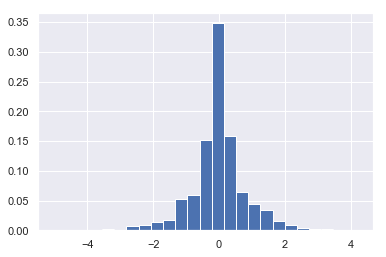

In [21]:
# a complex function, that specifies a complex sampling process:
def foo():
    a = pyro.sample('a', dist.Normal(0, 1))
    b = pyro.sample('b', dist.Normal(0, 1))
    return a * b

# make the marginal distributions on return values explicit:
samples = Infer(foo, num_samples=1000)

# now we can use d as we would any other distribution:
print(samples[:5])

viz(samples, plot_args={'bins': 25})

Note that `Infer` took an object describing *how* to construct the marginal distribution (which we will describe more later) and a thunk describing the sampling process, or *model*, of interest.

`pyro.sample` lets us sample from a distribution, and build complex sampling processes by using sampling in a program. Conversely, `TracePosterior` and `Marginal` (used here in `Infer`) let us reify the distribution implicitly described by a sampling process. 

When we think about probabilistic programs we will often move back and forth between these two views, emphasizing either the sampling perspective or the distributional perspective. With suitable restrictions this duality is complete: any Pyro program implicitly represents a distribution and any distribution can be represented by a Pyro program. See `Ackerman 2011` for more details on this duality.


# The rules of probability

While `Infer` lets us build the marginal distribution for even very complicated programs, we can also derive these marginal distributions with the "rules of probability". This is intractable for complex processes, but can help us build intuition for how distributions work.

## Product Rule

In the above example we take three steps to compute the output value: we sample from the first `flip()`, then from the second, then we make a list from these values.
To make this more clear let us re-write the program as:

In [22]:
A = flip()
B = flip()
C = [A, B]
C

[tensor(1.), tensor(1.)]

We can directly observe (as we did above) that the probability of `true` for `A` is 0.5, and the probability of `false` from `B` is 0.5. Can we use these two probabilities to arrive at the probability of 0.25 for the overall outcome `C` = `[true, false]`? Yes, using the *product rule* of probabilities:
The probability of two random choices is the product of their individual probabilities.
The probability of several random choices together is often called the *joint probability* and written as $P(A,B)$.
Since the first and second random choices must each have their specified values in order to get `[true, false]` in the example, the joint probability is their product: 0.25.

We must be careful when applying this rule, since the probability of a choice can depend on the probabilities of previous choices. For instance, compute the probability of `[true, false]` resulting from this program:

In [23]:
A = flip()
B = flip(0.3 if A else 0.7)
[A, B]

[tensor(0.), tensor(0.)]

In general, the joint probability of two random choices $A$ and $B$ made sequentially, in that order, can be written as $P(A,B) = P(A) P(B \vert A)$.
This is read as the product of the probability of $A$ and the probability of "$B$ given $A$", or "$B$ conditioned on $A$".
That is, the probability of making choice $B$ given that choice $A$ has been made in a certain way.
Only when the second choice does not depend on (or "look at") the first choice does this expression reduce to a simple product of the probabilities of each choice individually: $P(A,B) = P(A) P(B)$.

What is the relation between $P(A,B)$ and $P(B,A)$, the joint probability of the same choices written in the opposite order?  The only logically consistent definitions of probability require that these two probabilities be equal, so $P(A) P(B \vert A) = P(B) P(A \vert B)$.  This is the basis of *Bayes' theorem*, which we will encounter later.

## Sum Rule

Now let's consider an example where we can't determine from the overall return value the sequence of random choices that were made:

In [24]:
flip() or flip()

tensor(1.)

We can sample from this program and determine that the probability of returning `true` is about 0.75.

In [25]:
np.mean([(flip() or flip()) for _ in range(1000)])

0.773

We cannot simply use the product rule to determine this probability because we don't know the sequence of random choices that led to this return value.
However we can notice that the program will return true if the two component choices are `[true,true]`, or `[true,false]`, or `[false,true]`. To combine these possibilities we use another rule for probabilities:
If there are two alternative sequences of choices that lead to the same return value, the probability of this return value is the sum of the probabilities of the sequences.
We can write this using probability notation as: $P(A) = \sum_{B} P(A,B)$, where we view $A$ as the final value and $B$ as a random choice on the way to that value.
Using the product rule we can determine that the probability in the example above is 0.25 for each sequence that leads to return value `true`, then, by the sum rule, the probability of `true` is 0.25+0.25+0.25=0.75.

Using the sum rule to compute the probability of a final value is called is sometimes called *marginalization*, because the final distribution is the marginal distribution on final values.
From the point of view of sampling processes marginalization is simply ignoring (or not looking at) intermediate random values that are created on the way to a final return value.
From the point of view of directly computing probabilities, marginalization is summing over all the possible "histories" that could lead to a return value.
Putting the product and sum rules together, the marginal probability of return values from a program that we have explored above is the sum over sampling histories of the product over choice probabilities---a computation that can quickly grow unmanageable, but can be approximated by `Infer`.

# Stochastic recursion

[Recursive functions](https://en.wikipedia.org/wiki/Recursion_(computer_science)) are a powerful way to structure computation in deterministic systems.

In Pyro it is possible to have a *stochastic* recursion that randomly decides whether to stop.
For example, the *geometric distribution* is a probability distribution over the non-negative integers.
We imagine flipping a (weighted) coin, returning $N-1$ if the first `1` is on the Nth flip (that is, we return the number of times we get `0` before our first `1`):

<!--
g = pyro.infer.Importance(geometric, num_samples=1000)
marginal = pyro.infer.EmpiricalMarginal(g.run(0.6))
samples = marginal.sample(torch.Size([1000]))
-->

<BarContainer object of 9 artists>

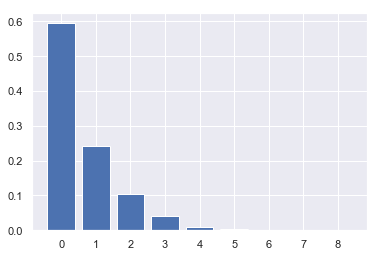

In [26]:
def geometric(p, t=0):
    # x = pflip(f"x_{t}", p)    # equivalent in this case
    x = flip(p)
    return torch.tensor(0) if x else 1 + geometric(p, t + 1)

# make the marginal distributions on return values explicit:
samples = Infer(lambda: geometric(p=0.6))

labels, counts = np.unique(samples, return_counts=True, axis=0)
probs = counts / np.sum(counts)
plt.bar(range(len(labels)), probs, align='center', tick_label=[str(w) for w in labels])

There is no upper bound on how long the computation can go on, although the probability of reaching some number declines quickly as we go.
Indeed, stochastic recursions must be constructed to halt eventually (with probability 1).


# Persistent Randomness: `memoize`

In [27]:
def memoize(fn=None, **kwargs):
    if fn is None:
        return lambda _fn: memoize(_fn, **kwargs)
    return functools.lru_cache(**kwargs)(fn)

It is often useful to model a set of objects that each have a randomly chosen property. For instance, describing the eye colors of a set of people:

In [28]:
EYE_COLORS = ['blue', 'green', 'brown']

def eye_color(person):
    i = dist.Categorical(torch.ones(3)).sample()
    return EYE_COLORS[i]

print('bob', eye_color('bob'))
print('alice', eye_color('alice'))
print('bob', eye_color('bob'))

bob brown
alice green
bob green


The results of this generative process are clearly wrong: Bob's eye color can change each time we ask about it! What we want is a model in which eye color is random, but *persistent.* We can do this using `memoize`.  `memoize` is a higher order function that takes a procedure and produces a *memoized* version of the procedure.

When a stochastic procedure is memoized, it will sample a random value the *first* time it is used with some arguments, but return that same value when called with those arguments thereafter.
The resulting memoized procedure has a persistent value within each "run" of the generative model (or simulated world). 

We can draw samples from a categorical distribution with 10 categories:

In [29]:
def cat(n=10):
    return dist.Categorical(torch.ones(n)).sample()

[cat() for _ in range(10)]

[tensor(2),
 tensor(5),
 tensor(2),
 tensor(3),
 tensor(9),
 tensor(0),
 tensor(3),
 tensor(6),
 tensor(6),
 tensor(1)]

Memoizing this function, all draws with equivalent input (i.e. no args) will return the same value

In [30]:
@memoize
def memcat(n=10):
    return dist.Categorical(torch.ones(n)).sample()

[memcat() for _ in range(10)]

[tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(5)]

Now returning to the eye color example, we can represent the notion that eye color is random, but each person has a fixed eye color. No matter how many times we re-run this cell, bob will have the same eye color for both samples.

In [31]:
@memoize
def mem_eye_color(person):
    i = dist.Categorical(torch.ones(3)).sample()
    return EYE_COLORS[i]

print('bob', mem_eye_color('bob'))
print('alice', mem_eye_color('alice'))
print('bob', mem_eye_color('bob'))

bob brown
alice brown
bob brown


This type of modeling is called *random world* style `Mcallester (2008)`.

Note that we don't have to specify ahead of time the people whose eye color we will ask about: the distribution on eye colors is implicitly defined over the infinite set of possible people, but only constructed "lazily" when needed.
Memoizing stochastic functions thus provides a powerful toolkit to represent and reason about an unbounded set of properties of an unbounded set of objects.

For instance, here we define a function `flip_a_lot` that maps from an integer (or any other value) to a coin flip. We could use it to implicitly represent the $n$th flip of a particular coin, without having to actually flip the coin $n$ times.

In [32]:
flip_a_lot = memoize(lambda n: flip())

[[flip_a_lot(1), flip_a_lot(12), flip_a_lot(47), flip_a_lot(1548)],
 [flip_a_lot(1), flip_a_lot(12), flip_a_lot(47), flip_a_lot(1548)]]

[[tensor(1.), tensor(0.), tensor(1.), tensor(1.)],
 [tensor(1.), tensor(0.), tensor(1.), tensor(1.)]]

There are a countably infinite number of such flips, each independent
of all the others. The outcome of each, once determined, will always have the same value.

In computer science memoization is an important technique for optimizing programs by avoiding repeated work.
In the probabilistic setting, such as in Pyro, memoization actually affects the meaning of the memoized function.

# Intuitive Physics Example   - TODO

```javascript
var listMin = function(xs) {
  if (xs.length == 1) {
    return xs[0]
  } else {
    return Math.min(xs[0], listMin(rest(xs)))
  }
}

var ground = {shape: 'rect', static: true, dims: [worldWidth, 10],
              x: worldWidth/2, y: worldHeight+6};

var stableWorld = [
  ground,
  {shape: 'rect', static: false, dims: [60, 22], x: 175, y: 473},
  {shape: 'rect', static: false, dims: [50, 38], x: 159.97995044874122, y: 413},
  {shape: 'rect', static: false, dims: [40, 35], x: 166.91912737427202, y: 340},
  {shape: 'rect', static: false, dims: [30, 29], x: 177.26195677111082, y: 276},
  {shape: 'rect', static: false, dims: [11, 17], x: 168.51354470809122, y: 230}
]

var almostUnstableWorld = [
  ground,
  {shape: 'rect', static: false, dims: [24, 22], x: 175, y: 473},
  {shape: 'rect', static: false, dims: [15, 38], x: 159.97995044874122, y: 413},
  {shape: 'rect', static: false, dims: [11, 35], x: 166.91912737427202, y: 340},
  {shape: 'rect', static: false, dims: [11, 29], x: 177.26195677111082, y: 276},
  {shape: 'rect', static: false, dims: [11, 17], x: 168.51354470809122, y: 230}
]

var unstableWorld = [
  ground,
  {shape: 'rect', static: false, dims: [60, 22], x: 175, y: 473},
  {shape: 'rect', static: false, dims: [50, 38], x: 90, y: 413},
  {shape: 'rect', static: false, dims: [40, 35], x: 140, y: 340},
  {shape: 'rect', static: false, dims: [10, 29], x: 177.26195677111082, y: 276},
  {shape: 'rect', static: false, dims: [50, 17], x: 140, y: 230}
]

var doesTowerFall = function (initialW, finalW) {
  var highestY = function (w) { listMin(map(function(obj) { return obj.y }, w)) }
  var approxEqual = function (a, b) { Math.abs(a - b) < 1.0 }
  !approxEqual(highestY(initialW), highestY(finalW))
}

var noisify = function (world) {
  var perturbX = function (obj) {
    var noiseWidth = 10
    obj.static ? obj : _.extend({}, obj, {x: uniform(obj.x - noiseWidth, obj.x + noiseWidth) })
  }
  map(perturbX, world)
}

var run = function(world) {
  var initialWorld = noisify(world)
  var finalWorld = physics.run(1000, initialWorld)
  doesTowerFall(initialWorld, finalWorld)
}

viz(
  Infer({method: 'forward', samples: 100},
        function() { run(stableWorld) }))
viz(
  Infer({method: 'forward', samples: 100},
        function() { run(almostUnstableWorld) }))
viz(
  Infer({method: 'forward', samples: 100},
        function() { run(unstableWorld) }))

// uncomment any of these that you'd like to see for yourself
// physics.animate(1000, stableWorld)
// physics.animate(1000, almostUnstableWorld)
// physics.animate(1000, unstableWorld)
```